<a href="https://colab.research.google.com/github/carolina-garay/AnalisisYCuracion_Grupo32/blob/carolina_Garay_AyC/AyC_Parte2__Garay_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Exploración y Curación de Datos**

*Edición 2021*

----

# Trabajo práctico entregable - parte 2
*Grupo 32*

Integrantes: 
- Garay, Carolina del Valle
- Ormaechea, Sebastián Gabriel
- Ramos, Pablo Nicolás

En el ejercicio 2 de la parte 1 del entregable seleccionaron las filas y columnas relevantes al problema de predicción de precios de una propiedad e imputaron los valores faltantes de las columnas `Suburb` y las columnas obtenidas a partir del conjunto de datos `airbnb`.

En esta notebook, **se utilizará resultado de dichas operaciones.** que fue guardado en un archivo (Ejercicio 3 entregable 1). 


In [1]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 80 kB 7.8 MB/s 


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import files
import joblib 
from sklearn import preprocessing
from category_encoders import one_hot


import seaborn as sns
sns.set_context('talk')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Descarga de base de datos
!gdown https://drive.google.com/file/d/185RVTSVvOg4DjAuUhv9UTy_QKPS4e6bp/view?usp=sharing --fuzzy

Downloading...
From: https://drive.google.com/uc?id=185RVTSVvOg4DjAuUhv9UTy_QKPS4e6bp
To: /content/Merge_df.csv
100% 2.74M/2.74M [00:00<00:00, 164MB/s]


In [4]:
# Lectura de csv y obtención de dataframe 
airmelb_df=pd.read_csv('/content/Merge_df.csv')

## Ejercicio 1: Encoding

1. Seleccionar todas las filas y columnas del conjunto de datos obtenido en la parte 1 del entregable, **excepto** `BuildingArea` y `YearBuilt`, que volveremos a imputar más adelante.

2. Aplicar una codificación One-hot encoding a cada fila, tanto para variables numéricas como categóricas. Si lo consideran necesario, pueden volver a reducir el número de categorías únicas.

Algunas opciones:
  1. Utilizar `OneHotEncoder` junto con el parámetro `categories` para las variables categóricas y luego usar `numpy.hstack` para concatenar el resultado con las variables numéricas. 
  2. `DictVectorizer` con algunos pasos de pre-proceso previo.

Recordar también que el atributo `pandas.DataFrame.values` permite acceder a la matriz de numpy subyacente a un DataFrame.


#**RESOLUCIÓN EJERCICIO 1**

1.1 Seleccionar todas las filas y columnas del conjunto de datos obtenido en la parte 1 del entregable, **excepto** `BuildingArea` y `YearBuilt`, que volveremos a imputar más adelante.

In [5]:
airmelb_df.head()

,Regionname,Suburb,Type,YearBuilt,BuildingArea,Car,Price,Postcode,Rooms,zipcode,AirB_record_count,AirB_daily_price_mean,AirB_weekly_price_mean,AirB_monthly_price_mean
0,Northern Metropolitan,Abbotsford,h,NaN,NaN,1.0,1480000.0,3067.0,2,3067.0,157.0,140.292994,236.250000,956.363636
1,Northern Metropolitan,Abbotsford,h,NaN,NaN,1.0,1480000.0,3067.0,2,3067.0,101.0,115.594059,735.352941,2863.900000
2,Northern Metropolitan,Abbotsford,h,1900.0,79.0,0.0,1035000.0,3067.0,2,3067.0,157.0,140.292994,236.250000,956.363636
3,Northern Metropolitan,Abbotsford,h,1900.0,79.0,0.0,1035000.0,3067.0,2,3067.0,101.0,115.594059,735.352941,2863.900000
4,Northern Metropolitan,Abbotsford,h,1900.0,150.0,0.0,1465000.0,3067.0,3,3067.0,157.0,140.292994,236.250000,956.363636


In [6]:
airmelb_df.columns

Index(['Regionname', 'Suburb', 'Type', 'YearBuilt', 'BuildingArea', 'Car',
       'Price', 'Postcode', 'Rooms', 'zipcode', 'AirB_record_count',
       'AirB_daily_price_mean', 'AirB_weekly_price_mean',
       'AirB_monthly_price_mean'],
      dtype='object')

In [7]:
#Selección de columnas
df= airmelb_df[['Regionname', 'Type','Car', 'Price', 'Postcode', 'Rooms',
        'AirB_record_count', 'AirB_daily_price_mean',
       'AirB_weekly_price_mean', 'AirB_monthly_price_mean']]

In [8]:
df[:3]

,Regionname,Type,Car,Price,Postcode,Rooms,AirB_record_count,AirB_daily_price_mean,AirB_weekly_price_mean,AirB_monthly_price_mean
0,Northern Metropolitan,h,1.0,1480000.0,3067.0,2,157.0,140.292994,236.250000,956.363636
1,Northern Metropolitan,h,1.0,1480000.0,3067.0,2,101.0,115.594059,735.352941,2863.900000
2,Northern Metropolitan,h,0.0,1035000.0,3067.0,2,157.0,140.292994,236.250000,956.363636


In [9]:
df.isnull().sum().sum()

24732

Obervamos que hay registros con valores NAN, esto nos llevará a que en algún momento debamos decidir imputar más de una vez.

In [10]:
df.select_dtypes(include=['float64', 'int']).describe()

,Car,Price,Postcode,Rooms,AirB_record_count,AirB_daily_price_mean,AirB_weekly_price_mean,AirB_monthly_price_mean
count,25740.000000,2.574000e+04,25740.000000,25740.000000,25707.000000,25707.000000,13673.000000,13141.000000
mean,1.579254,1.037024e+06,3104.029876,2.908159,81.107792,134.512111,685.446882,2574.504864
std,0.918221,5.272609e+05,86.376050,0.946957,149.922991,96.215809,338.678344,1450.177201
min,0.000000,2.100000e+05,3000.000000,1.000000,3.000000,41.764706,160.000000,600.000000
25%,1.000000,6.500000e+05,3044.000000,2.000000,20.000000,93.678571,441.916667,1550.000000
50%,2.000000,9.020000e+05,3084.000000,3.000000,40.000000,113.929204,606.750000,2224.600000
75%,2.000000,1.315000e+06,3148.000000,3.000000,81.000000,145.807692,896.055556,3366.666667
max,6.000000,2.990000e+06,3977.000000,10.000000,2491.000000,1407.666667,2236.666667,10060.000000



2.2 Aplicar una codificación One-hot encoding a cada fila, tanto para variables numéricas como categóricas. Si lo consideran necesario, pueden volver a reducir el número de categorías únicas.

La binarización (one-hot-encoding) consiste en crear nuevas variables dummy con cada uno de los niveles de las variables cualitativas. Por ejemplo, una variable llamada color que contenga los niveles rojo, verde y azul, se convertirá en tres nuevas variables (color_rojo, color_verde, color_azul), todas con el valor 0 excepto la que coincide con la observación, que toma el valor 1.

In [11]:
#Imprimimos tipo de dato de cada columna
df.dtypes

Regionname                  object
Type                        object
Car                        float64
Price                      float64
Postcode                   float64
Rooms                        int64
AirB_record_count          float64
AirB_daily_price_mean      float64
AirB_weekly_price_mean     float64
AirB_monthly_price_mean    float64
dtype: object

In [12]:
#Imprimimos nombre de cada columna
df.columns

Index(['Regionname', 'Type', 'Car', 'Price', 'Postcode', 'Rooms',
       'AirB_record_count', 'AirB_daily_price_mean', 'AirB_weekly_price_mean',
       'AirB_monthly_price_mean'],
      dtype='object')

In [13]:
#Separamos por variables categóricas y numéricas
categorical_cols = ['Regionname', 'Type']
numerical_cols = ['Car', 'Price', 'Postcode', 'Rooms',
        'AirB_record_count', 'AirB_daily_price_mean',
       'AirB_weekly_price_mean', 'AirB_monthly_price_mean']

Inspeccionamos las variables categóricas

In [14]:
#Imprimimos cantidad de categorías que toma cada variable categórica
df[categorical_cols].nunique()

Regionname    8
Type          3
dtype: int64

In [15]:
#Imprimimos cantidad de valores que toma cada categoría de la variable Regionname
df.value_counts('Regionname')


Regionname
Southern Metropolitan         8918
Northern Metropolitan         7350
Western Metropolitan          5575
Eastern Metropolitan          2887
South-Eastern Metropolitan     831
Eastern Victoria                80
Western Victoria                51
Northern Victoria               48
dtype: int64

In [16]:
#Imprimimos cantidad de valores que toma cada categoría de la variable Suburb
#df.value_counts('Suburb')


Nota: El atributo 'Suburb' presentaba más de 300 categorías, es por ellos que decidimos no codificarla.

In [17]:
#Imprimimos cantidad de valores que toma cada categoría de la variable Type
df.value_counts('Type')


Type
h    17596
u     5957
t     2187
dtype: int64

#Método :  Codificación One-Hot Encoder



In [18]:
# Creación de instancias del objeto OHE de codificadores de categoría 
ce_ohe = one_hot.OneHotEncoder(use_cat_names = True)

In [19]:
ce_dummies = ce_ohe.fit_transform(df[categorical_cols])

In [20]:
ce_dummies 

,Regionname_Northern Metropolitan,Regionname_Western Metropolitan,Regionname_Southern Metropolitan,Regionname_Eastern Metropolitan,Regionname_South-Eastern Metropolitan,Regionname_Eastern Victoria,Regionname_Northern Victoria,Regionname_Western Victoria,Type_h,Type_u,Type_t
0,1,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
25735,0,1,0,0,0,0,0,0,1,0,0
25736,0,1,0,0,0,0,0,0,1,0,0
25737,0,1,0,0,0,0,0,0,1,0,0
25738,0,1,0,0,0,0,0,0,1,0,0


In [21]:
# Eliminamos las variables categóricas
df = df.drop(columns=['Regionname', 'Type'])

In [22]:
df_new = pd.concat([ce_dummies,df], axis = 1)

In [23]:
df_new

,Regionname_Northern Metropolitan,Regionname_Western Metropolitan,Regionname_Southern Metropolitan,Regionname_Eastern Metropolitan,Regionname_South-Eastern Metropolitan,Regionname_Eastern Victoria,Regionname_Northern Victoria,Regionname_Western Victoria,Type_h,Type_u,Type_t,Car,Price,Postcode,Rooms,AirB_record_count,AirB_daily_price_mean,AirB_weekly_price_mean,AirB_monthly_price_mean
0,1,0,0,0,0,0,0,0,1,0,0,1.0,1480000.0,3067.0,2,157.0,140.292994,236.250000,956.363636
1,1,0,0,0,0,0,0,0,1,0,0,1.0,1480000.0,3067.0,2,101.0,115.594059,735.352941,2863.900000
2,1,0,0,0,0,0,0,0,1,0,0,0.0,1035000.0,3067.0,2,157.0,140.292994,236.250000,956.363636
3,1,0,0,0,0,0,0,0,1,0,0,0.0,1035000.0,3067.0,2,101.0,115.594059,735.352941,2863.900000
4,1,0,0,0,0,0,0,0,1,0,0,0.0,1465000.0,3067.0,3,157.0,140.292994,236.250000,956.363636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25735,0,1,0,0,0,0,0,0,1,0,0,4.0,1170000.0,3016.0,3,20.0,167.200000,633.000000,2163.000000
25736,0,1,0,0,0,0,0,0,1,0,0,5.0,2500000.0,3016.0,4,54.0,199.944444,550.000000,1990.000000
25737,0,1,0,0,0,0,0,0,1,0,0,5.0,2500000.0,3016.0,4,20.0,167.200000,633.000000,2163.000000
25738,0,1,0,0,0,0,0,0,1,0,0,1.0,1285000.0,3013.0,4,42.0,127.523810,NaN,NaN


## Ejercicio 2: Imputación por KNN

En el teórico se presentó el método `IterativeImputer` para imputar valores faltantes en variables numéricas. Sin embargo, los ejemplos presentados sólo utilizaban algunas variables numéricas presentes en el conjunto de datos. En este ejercicio, utilizaremos la matriz de datos codificada para imputar datos faltantes de manera más precisa.

1. Agregue a la matriz obtenida en el punto anterior las columnas `YearBuilt` y `BuildingArea`.
2. Aplique una instancia de `IterativeImputer` con un estimador `KNeighborsRegressor` para imputar los valores de las variables. ¿Es necesario estandarizar o escalar los datos previamente?
3. Realice un gráfico mostrando la distribución de cada variable antes de ser imputada, y con ambos métodos de imputación.

#**RESOLUCIÓN EJERCICIO 2**

2.1 Agregue a la matriz obtenida en el punto anterior las columnas `YearBuilt` y `BuildingArea`.

In [24]:
df_ = airmelb_df[['YearBuilt','BuildingArea']]

In [25]:
# Añadimos el dataframe creado en el punto anterior a
#  df_ (dataframe que contenía las variables 'YearBuilt' y 'BuildingArea')
df_ = pd.concat([df_, df_new], axis = 1)

In [26]:
#Imprimimos dataframe unido
df_

,YearBuilt,BuildingArea,Regionname_Northern Metropolitan,Regionname_Western Metropolitan,Regionname_Southern Metropolitan,Regionname_Eastern Metropolitan,Regionname_South-Eastern Metropolitan,Regionname_Eastern Victoria,Regionname_Northern Victoria,Regionname_Western Victoria,...,Type_u,Type_t,Car,Price,Postcode,Rooms,AirB_record_count,AirB_daily_price_mean,AirB_weekly_price_mean,AirB_monthly_price_mean
0,NaN,NaN,1,0,0,0,0,0,0,0,...,0,0,1.0,1480000.0,3067.0,2,157.0,140.292994,236.250000,956.363636
1,NaN,NaN,1,0,0,0,0,0,0,0,...,0,0,1.0,1480000.0,3067.0,2,101.0,115.594059,735.352941,2863.900000
2,1900.0,79.0,1,0,0,0,0,0,0,0,...,0,0,0.0,1035000.0,3067.0,2,157.0,140.292994,236.250000,956.363636
3,1900.0,79.0,1,0,0,0,0,0,0,0,...,0,0,0.0,1035000.0,3067.0,2,101.0,115.594059,735.352941,2863.900000
4,1900.0,150.0,1,0,0,0,0,0,0,0,...,0,0,0.0,1465000.0,3067.0,3,157.0,140.292994,236.250000,956.363636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25735,1997.0,NaN,0,1,0,0,0,0,0,0,...,0,0,4.0,1170000.0,3016.0,3,20.0,167.200000,633.000000,2163.000000
25736,1920.0,157.0,0,1,0,0,0,0,0,0,...,0,0,5.0,2500000.0,3016.0,4,54.0,199.944444,550.000000,1990.000000
25737,1920.0,157.0,0,1,0,0,0,0,0,0,...,0,0,5.0,2500000.0,3016.0,4,20.0,167.200000,633.000000,2163.000000
25738,1920.0,112.0,0,1,0,0,0,0,0,0,...,0,0,1.0,1285000.0,3013.0,4,42.0,127.523810,NaN,NaN


2.2 Aplique una instancia de `IterativeImputer` con un estimador `KNeighborsRegressor` para imputar los valores de las variables. ¿Es necesario estandarizar o escalar los datos previamente?

#Realizamos imputación

In [27]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import IterativeImputer

df_imp = df_.copy(deep=True)

knn_imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor())
df_imp[['YearBuilt','BuildingArea']] = knn_imputer.fit_transform(
    df_imp[['YearBuilt', 'BuildingArea']])

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


In [28]:
df_imp[:10]

,YearBuilt,BuildingArea,Regionname_Northern Metropolitan,Regionname_Western Metropolitan,Regionname_Southern Metropolitan,Regionname_Eastern Metropolitan,Regionname_South-Eastern Metropolitan,Regionname_Eastern Victoria,Regionname_Northern Victoria,Regionname_Western Victoria,...,Type_u,Type_t,Car,Price,Postcode,Rooms,AirB_record_count,AirB_daily_price_mean,AirB_weekly_price_mean,AirB_monthly_price_mean
0,1974.0,166.6,1,0,0,0,0,0,0,0,...,0,0,1.0,1480000.0,3067.0,2,157.0,140.292994,236.250000,956.363636
1,1974.0,166.6,1,0,0,0,0,0,0,0,...,0,0,1.0,1480000.0,3067.0,2,101.0,115.594059,735.352941,2863.900000
2,1900.0,79.0,1,0,0,0,0,0,0,0,...,0,0,0.0,1035000.0,3067.0,2,157.0,140.292994,236.250000,956.363636
3,1900.0,79.0,1,0,0,0,0,0,0,0,...,0,0,0.0,1035000.0,3067.0,2,101.0,115.594059,735.352941,2863.900000
4,1900.0,150.0,1,0,0,0,0,0,0,0,...,0,0,0.0,1465000.0,3067.0,3,157.0,140.292994,236.250000,956.363636
5,1900.0,150.0,1,0,0,0,0,0,0,0,...,0,0,0.0,1465000.0,3067.0,3,101.0,115.594059,735.352941,2863.900000
6,1974.0,166.6,1,0,0,0,0,0,0,0,...,0,0,1.0,850000.0,3067.0,3,157.0,140.292994,236.250000,956.363636
7,1974.0,166.6,1,0,0,0,0,0,0,0,...,0,0,1.0,850000.0,3067.0,3,101.0,115.594059,735.352941,2863.900000
8,2014.0,142.0,1,0,0,0,0,0,0,0,...,0,0,2.0,1600000.0,3067.0,4,157.0,140.292994,236.250000,956.363636
9,2014.0,142.0,1,0,0,0,0,0,0,0,...,0,0,2.0,1600000.0,3067.0,4,101.0,115.594059,735.352941,2863.900000


2.3 Realice un gráfico mostrando la distribución de cada variable antes de ser imputada, y con ambos métodos de imputación.

Graficamos las variables 'YearBuilt' y 'BuildingArea' antes de realizar imputación

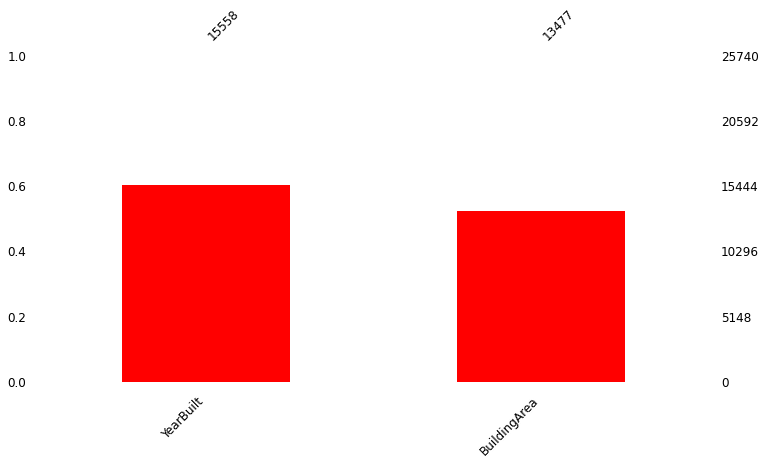

In [29]:
import missingno as msno
msno.bar(df_[['YearBuilt','BuildingArea']],figsize=(12, 6), fontsize=12, color='red');

Graficamos las variables 'YearBuilt' y 'BuildingArea' después de realizar imputación

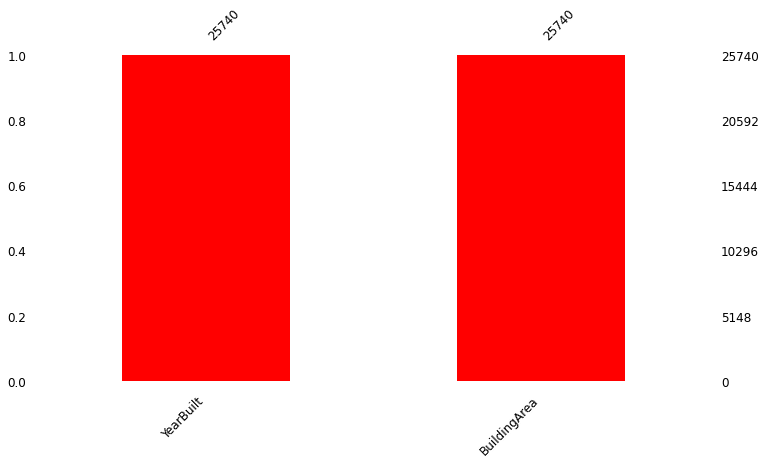

In [30]:
msno.bar(df_imp[['YearBuilt','BuildingArea']],figsize=(12, 6), fontsize=12, color='red');

Comparación de las distribuciones de datos obtenidas con cada método de imputación.

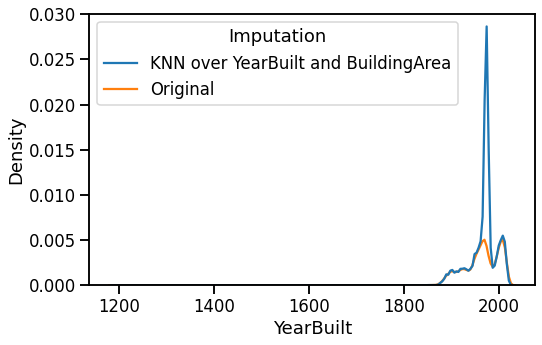

In [31]:
df_imp_year_built = df_imp.YearBuilt.to_frame()
df_imp_year_built['Imputation'] = 'KNN over YearBuilt and BuildingArea'
df_imp_year_build = df_.YearBuilt.dropna().to_frame()
df_imp_year_build['Imputation'] = 'Original'
data = pd.concat([df_imp_year_built, df_imp_year_build], ignore_index=True)
fig = plt.figure(figsize=(8, 5))
g = sns.kdeplot(data=data, x='YearBuilt', hue='Imputation')

## Ejercicio 3: Reducción de dimensionalidad.

Utilizando la matriz obtenida en el ejercicio anterior:
1. Aplique `PCA` para obtener $n$ componentes principales de la matriz, donde `n = min(20, X.shape[0])`. ¿Es necesario estandarizar o escalar los datos?
2. Grafique la varianza capturada por los primeros $n$ componentes principales, para cada $n$.
3. En base al gráfico, seleccione las primeras $m$ columnas de la matriz transformada para agregar como nuevas características al conjunto de datos.

#**RESOLUCIÓN EJERCICIO 3**

3.1 Aplique `PCA` para obtener $n$ componentes principales de la matriz, donde `n = min(20, X.shape[0])`. ¿Es necesario estandarizar o escalar los datos

Dado que los distintos atributos de nuestro dataset están expresadas en diferentes unidades se hace necesario estandarizar sus valores.

In [32]:
from sklearn.preprocessing import MinMaxScaler

In [33]:
#imprimimos nombre de cada columna para utilizarlas en la estandarización
df_imp.columns

Index(['YearBuilt', 'BuildingArea', 'Regionname_Northern Metropolitan',
       'Regionname_Western Metropolitan', 'Regionname_Southern Metropolitan',
       'Regionname_Eastern Metropolitan',
       'Regionname_South-Eastern Metropolitan', 'Regionname_Eastern Victoria',
       'Regionname_Northern Victoria', 'Regionname_Western Victoria', 'Type_h',
       'Type_u', 'Type_t', 'Car', 'Price', 'Postcode', 'Rooms',
       'AirB_record_count', 'AirB_daily_price_mean', 'AirB_weekly_price_mean',
       'AirB_monthly_price_mean'],
      dtype='object')

In [34]:
columns_escala = ['YearBuilt', 'BuildingArea', 'Regionname_Northern Metropolitan',
       'Regionname_Western Metropolitan', 'Regionname_Southern Metropolitan',
       'Regionname_Eastern Metropolitan',
       'Regionname_South-Eastern Metropolitan', 'Regionname_Eastern Victoria',
       'Regionname_Northern Victoria', 'Regionname_Western Victoria', 'Type_h',
       'Type_u', 'Type_t', 'Car', 'Price', 'Postcode', 'Rooms',
       'AirB_record_count', 'AirB_daily_price_mean', 'AirB_weekly_price_mean',
       'AirB_monthly_price_mean']

In [35]:
escala = MinMaxScaler()
escala.fit(df_imp[columns_escala])
df_imp.loc[:, columns_escala] = escala.transform(df_imp[columns_escala])

In [36]:
df_imp

,YearBuilt,BuildingArea,Regionname_Northern Metropolitan,Regionname_Western Metropolitan,Regionname_Southern Metropolitan,Regionname_Eastern Metropolitan,Regionname_South-Eastern Metropolitan,Regionname_Eastern Victoria,Regionname_Northern Victoria,Regionname_Western Victoria,...,Type_u,Type_t,Car,Price,Postcode,Rooms,AirB_record_count,AirB_daily_price_mean,AirB_weekly_price_mean,AirB_monthly_price_mean
0,0.946472,0.003743,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.166667,0.456835,0.068577,0.111111,0.061897,0.072134,0.036717,0.037671
1,0.946472,0.003743,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.166667,0.456835,0.068577,0.111111,0.039389,0.054052,0.277056,0.239313
2,0.856448,0.001775,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.296763,0.068577,0.111111,0.061897,0.072134,0.036717,0.037671
3,0.856448,0.001775,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.296763,0.068577,0.111111,0.039389,0.054052,0.277056,0.239313
4,0.856448,0.003370,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.451439,0.068577,0.222222,0.061897,0.072134,0.036717,0.037671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25735,0.974453,0.005212,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.666667,0.345324,0.016377,0.222222,0.006833,0.091833,0.227769,0.165222
25736,0.880779,0.003527,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.833333,0.823741,0.016377,0.333333,0.020498,0.115806,0.187801,0.146934
25737,0.880779,0.003527,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.833333,0.823741,0.016377,0.333333,0.006833,0.091833,0.227769,0.165222
25738,0.880779,0.002516,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.166667,0.386691,0.013306,0.333333,0.015675,0.062786,NaN,NaN


El siguiente análisis de valores NAN lo realizamos luego de que al aplicar el método PCA nos arrojara un error con respecto a valores NAN.

In [37]:
#Mostramos en qué columnas se encuentran los valores NaN:
df_imp.isnull().any()

YearBuilt                                False
BuildingArea                             False
Regionname_Northern Metropolitan         False
Regionname_Western Metropolitan          False
Regionname_Southern Metropolitan         False
Regionname_Eastern Metropolitan          False
Regionname_South-Eastern Metropolitan    False
Regionname_Eastern Victoria              False
Regionname_Northern Victoria             False
Regionname_Western Victoria              False
Type_h                                   False
Type_u                                   False
Type_t                                   False
Car                                      False
Price                                    False
Postcode                                 False
Rooms                                    False
AirB_record_count                         True
AirB_daily_price_mean                     True
AirB_weekly_price_mean                    True
AirB_monthly_price_mean                   True
dtype: bool

In [38]:
#Imprimimos cantidad total de registros NaN 
df_imp.isnull().sum().sum()

24732

Dado que tenemos filas con valores NAN, decidimos volver a imputar

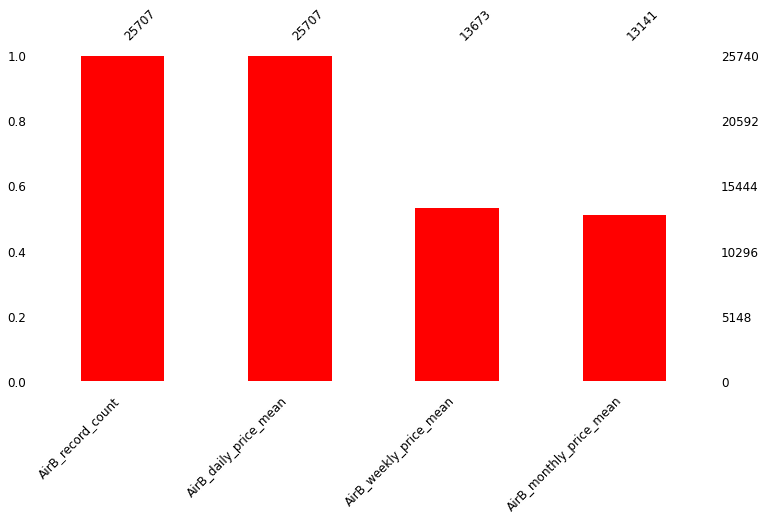

In [39]:
msno.bar(df_imp[['AirB_record_count','AirB_daily_price_mean','AirB_weekly_price_mean','AirB_monthly_price_mean' ]],figsize=(12, 6), fontsize=12, color='red');

In [40]:
df_imp2 = df_imp.copy(deep=True)

knn_imputer2 = IterativeImputer(random_state=0, estimator=KNeighborsRegressor())
df_imp2[['AirB_record_count','AirB_daily_price_mean','AirB_weekly_price_mean','AirB_monthly_price_mean']] = knn_imputer2.fit_transform(
    df_imp2[['AirB_record_count','AirB_daily_price_mean','AirB_weekly_price_mean','AirB_monthly_price_mean']])

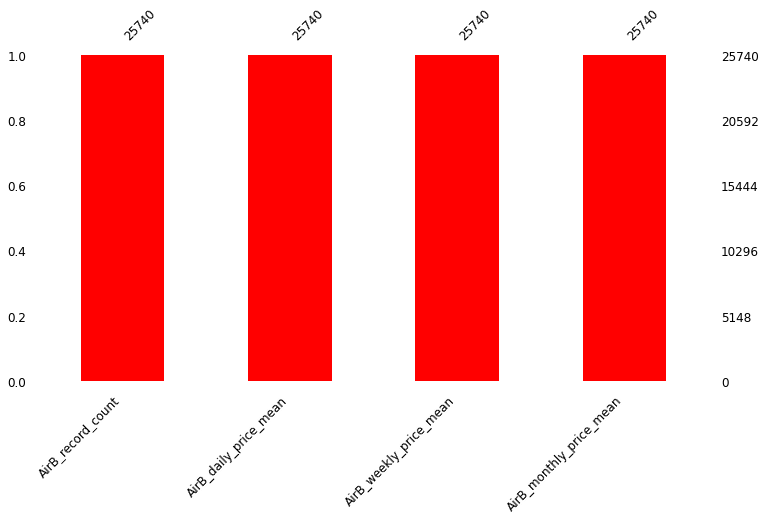

In [41]:
msno.bar(df_imp2[['AirB_record_count','AirB_daily_price_mean','AirB_weekly_price_mean','AirB_monthly_price_mean' ]],figsize=(12, 6), fontsize=12, color='red');

**Entrenamos la instancia de la clase PCA**

Al aplicar el método PCA nos arrojó un error de valores NAN. Inspeccionamos dichos valores y encontramos que correspondían a la base de datos AIRBNB. Es por ello que decidimos volver hacia atrás y realizamos imputación sobre los atributos que se correspondían con esos valores.

In [42]:
df_imp2.var(axis=0)

YearBuilt                                0.001280
BuildingArea                             0.000043
Regionname_Northern Metropolitan         0.204018
Regionname_Western Metropolitan          0.169685
Regionname_Southern Metropolitan         0.226436
Regionname_Eastern Metropolitan          0.099584
Regionname_South-Eastern Metropolitan    0.031243
Regionname_Eastern Victoria              0.003098
Regionname_Northern Victoria             0.001861
Regionname_Western Victoria              0.001978
Type_h                                   0.216298
Type_u                                   0.177877
Type_t                                   0.077749
Car                                      0.023420
Price                                    0.035972
Postcode                                 0.007816
Rooms                                    0.011071
AirB_record_count                        0.003627
AirB_daily_price_mean                    0.004956
AirB_weekly_price_mean                   0.020884


In [43]:
#Aplicamos el método PCA para el total de atributos
from sklearn.decomposition import PCA

n_comp=21
pca = PCA(n_comp)
pca.fit(df_imp2)
print("Principal components")
print(pca.components_)
print("Explained variance (Varianza Explicada) ")
print(pca.explained_variance_)
print("Explained variance ratio (Proporción de Varianza Explicada)")
print(pca.explained_variance_ratio_)

Principal components
[[ 1.06387083e-02 -6.32290167e-04 -1.65621829e-01 -1.89547853e-01
   4.57356768e-01 -7.47407869e-02 -2.15862855e-02 -2.29984216e-03
  -1.70567129e-03 -1.85450108e-03 -6.25666998e-01  5.43048354e-01
   8.26186436e-02 -5.89514778e-02 -7.13227551e-02  3.71766962e-02
  -7.99513635e-02  2.25681170e-02  1.59335948e-02  7.78649950e-02
   7.02793865e-02]
 [ 1.02102950e-02 -6.74453775e-04  6.46548352e-01 -2.09909153e-02
  -5.86592528e-01 -2.72086967e-02 -8.87584645e-03 -1.25829199e-03
  -8.87878085e-04 -7.34194808e-04 -3.26147205e-01  2.74649307e-01
   5.14978983e-02 -5.50114693e-02 -1.87717419e-01 -5.85926876e-02
  -6.29103781e-02  1.71919749e-02 -8.81395128e-03 -5.74705541e-02
  -5.22475607e-02]
 [ 1.14490176e-02 -2.02619725e-04 -4.80603711e-01  7.60358434e-01
  -3.18220625e-01  3.54619207e-02  3.42336463e-03 -2.16798304e-04
  -1.92720858e-04 -9.86450017e-06 -2.00416879e-01  1.47348169e-01
   5.30687098e-02  1.58033022e-03 -1.30620905e-01 -5.81002739e-02
  -1.64001566e-02

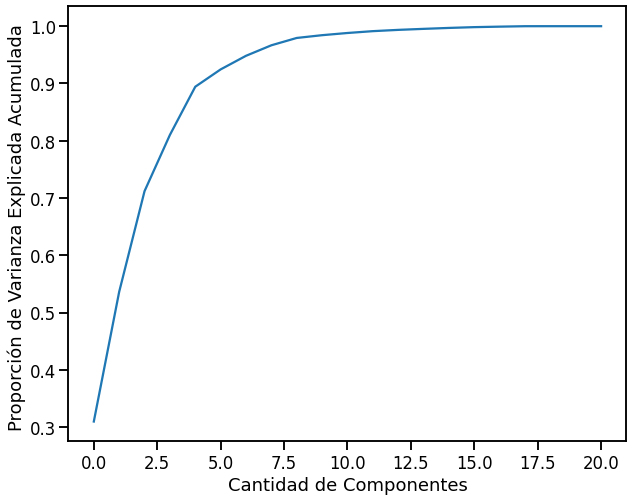

In [45]:
#Graficamos la Proporción de Varianza Explicada acumulada para todas las componentes
n_comp=21
pca = PCA(n_comp)
princ_comp = pca.fit(df_imp2)
var_n = pca.explained_variance_ratio_
eje_y=np.cumsum(var_n)
fig = plt.figure(figsize=(10, 8))
plt.plot(np.cumsum(var_n))
plt.xlabel('Cantidad de Componentes')
plt.ylabel('Proporción de Varianza Explicada Acumulada ')
plt.show()

Observamos que a partir de 7.5 componentes el incremento en la Proporción de la Varianza Explicada acumulada deja de ser sustancial. Decidimos si elegimos 7 u 8 componenetes imprimendo la suma de la Proporción de la Varianza explicada.

In [46]:
#Imprimos la suma de la proporción de la varianza explicada para decidir 
#cantidad de componentes. 
np.cumsum(pca.explained_variance_ratio_)

array([0.30994602, 0.53638096, 0.71205714, 0.81020335, 0.8943241 ,
       0.9245572 , 0.94829852, 0.96665364, 0.97945987, 0.98429596,
       0.98811466, 0.99133283, 0.99355924, 0.99533216, 0.99696511,
       0.99833326, 0.99919428, 0.99996876, 1.        , 1.        ,
       1.        ])

De los resultados anterioriores vemos que 8 componentes resultan suficientes para explicar los datos considerando el 97% del total de datos.

In [47]:
#Aplicamos PCA para el número de componentes que 
#decidimos en el paso anterior
n_comp=8
pca = PCA(n_comp)
princ_comp = pca.fit(df_imp2)
print("Principal components")
"""Cada número es el peso que se le asigna a los 21 atributos y luego se
"suma la multiplicación del peso*atributo para obtener la componente principal"""
print(pca.components_)
print("Explained variance: ")
print(pca.explained_variance_)
print("Explained variance ratio")
print(pca.explained_variance_ratio_)

Principal components
[[ 1.06387083e-02 -6.32290167e-04 -1.65621829e-01 -1.89547853e-01
   4.57356768e-01 -7.47407869e-02 -2.15862855e-02 -2.29984216e-03
  -1.70567129e-03 -1.85450108e-03 -6.25666998e-01  5.43048354e-01
   8.26186436e-02 -5.89514778e-02 -7.13227551e-02  3.71766962e-02
  -7.99513635e-02  2.25681170e-02  1.59335948e-02  7.78649950e-02
   7.02793865e-02]
 [ 1.02102950e-02 -6.74453775e-04  6.46548352e-01 -2.09909153e-02
  -5.86592528e-01 -2.72086967e-02 -8.87584645e-03 -1.25829199e-03
  -8.87878085e-04 -7.34194808e-04 -3.26147205e-01  2.74649307e-01
   5.14978983e-02 -5.50114693e-02 -1.87717419e-01 -5.85926876e-02
  -6.29103781e-02  1.71919749e-02 -8.81395128e-03 -5.74705541e-02
  -5.22475607e-02]
 [ 1.14490176e-02 -2.02619725e-04 -4.80603711e-01  7.60358434e-01
  -3.18220625e-01  3.54619207e-02  3.42336463e-03 -2.16798304e-04
  -1.92720858e-04 -9.86450017e-06 -2.00416879e-01  1.47348169e-01
   5.30687098e-02  1.58033022e-03 -1.30620905e-01 -5.81002739e-02
  -1.64001566e-02

3.2 Grafique la varianza capturada por los primeros $n$ componentes principales, para cada $n$.

In [53]:
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
porc=((pca.explained_variance_ratio_)*100)
print(porc)

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[30.99460196 22.64349447 17.56761712  9.81462138  8.41207516  3.02330947
  2.37413264  1.83551143]


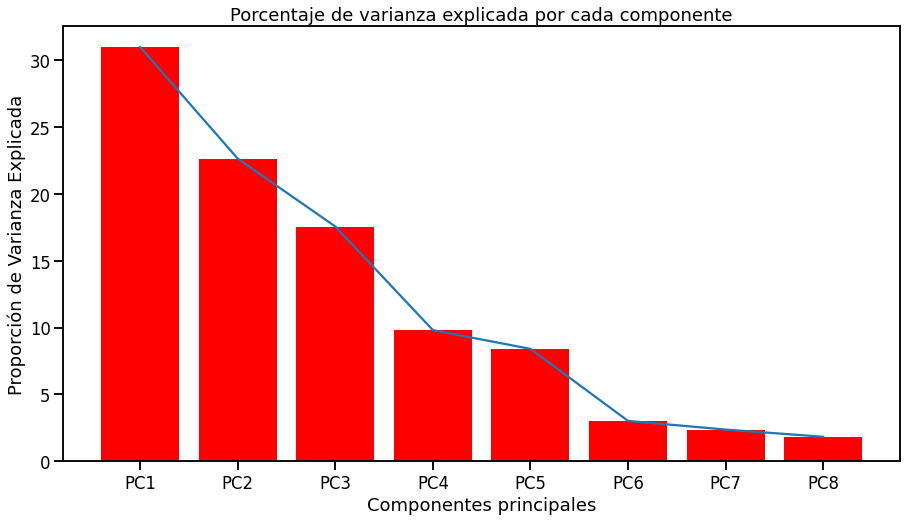

In [54]:
n_comp=8
pca = PCA(n_comp)
princ_comp = pca.fit(df_imp2)
var_expl = pca.explained_variance_ratio_
eje_y=np.cumsum(var_expl)
fig,ax = plt.subplots(figsize = [15,8])
ax.bar(x = [f"PC" + str(i) for i in range(1,n_comp+1)], height=porc, color="red")
ax.plot([f"PC" + str(i) for i in range(1,n_comp+1)], porc)
#ax.set_ylim([0,1])
ax.set_title('Porcentaje de varianza explicada por cada componente')
plt.xlabel('Componentes principales')
plt.ylabel("Proporción de Varianza Explicada")
plt.show()

En el gráfico anterior observamos que la primera componente explica el 30,99% de la varianza observada en los datos y la segunda el 22,64%. Las dos últimas componentes no superan por separado el 3% de la varianza.



3.3 En base al gráfico, seleccione las primeras $m$ columnas de la matriz transformada para agregar como nuevas características al conjunto de datos.

In [ ]:
df_pca= pca.transform(df_imp2)
df_components = pd.DataFrame(data=df_pca,
    columns =[f"PC" + str(i) for i in range(1,n_comp+1)])
df_components

In [ ]:
# Añadimos el dataframe que se creó al aplicar PCA al dataframe imputado df_imp2
df_final= pd.concat([df_imp2, df_components], axis = 1)
df_final

## Ejercicio 4: Composición del resultado

Transformar nuevamente el conjunto de datos procesado en un `pandas.DataFrame` y guardarlo en un archivo.

Para eso, será necesario recordar el nombre original de cada columna de la matriz, en el orden correcto. Tener en cuenta:
1. El método `OneHotEncoder.get_feature_names` o el atributo `OneHotEncoder.categories_` permiten obtener una lista con los valores de la categoría que le corresponde a cada índice de la matriz.
2. Ninguno de los métodos aplicados intercambia de lugar las columnas o las filas de la matriz.

#**RESOLUCIÓN EJERCICIO 4**

Transformar nuevamente el conjunto de datos procesado en un `pandas.DataFrame` y guardarlo en un archivo.

En el item 3.3 resolvimos trabajar directamnete con los dataframes. Unimos el daframe obtenido al aplicar PCA con el dataframe en el que habíamos imputado los valores a aquellos atributos que tenían valores NAN. El conjunto de datos procesados es el dataframe **df_final**.

In [ ]:
df_final

Transformamos el dataframe **df_final** a archivo de texto plano para luego ser descargado de ser necesario.

In [ ]:
df_final.to_csv("df_final_AyC_Grupo32.csv", index=None)


In [ ]:
#from google.colab import files
#files.download('df_final_AyC_Grupo32.csv')

## Ejercicio 5: Documentación

En un documento `.pdf` o `.md` realizar un reporte de las operaciones que realizaron para obtener el conjunto de datos final. Se debe incluir:
  1. Criterios de exclusión (o inclusión) de filas
  2. Interpretación de las columnas presentes
  2. Todas las transofrmaciones realizadas

Este documento es de uso técnico exclusivamente, y su objetivo es permitir que otres desarrolladores puedan reproducir los mismos pasos y obtener el mismo resultado. Debe ser detallado pero consiso. Por ejemplo:

```
  ## Criterios de exclusión de ejemplos
  1. Se eliminan ejemplos donde el año de construcción es previo a 1900

  ## Características seleccionadas
  ### Características categóricas
  1. Type: tipo de propiedad. 3 valores posibles
  2. ...
  Todas las características categóricas fueron codificadas con un
  método OneHotEncoding utilizando como máximo sus 30 valores más 
  frecuentes.
  
  ### Características numéricas
  1. Rooms: Cantidad de habitaciones
  2. Distance: Distancia al centro de la ciudad.
  3. airbnb_mean_price: Se agrega el precio promedio diario de 
     publicaciones de la plataforma AirBnB en el mismo código 
     postal. [Link al repositorio con datos externos].

  ### Transformaciones:
  1. Todas las características numéricas fueron estandarizadas.
  2. La columna `Suburb` fue imputada utilizando el método ...
  3. Las columnas `YearBuilt` y ... fueron imputadas utilizando el 
     algoritmo ...
  4. ...

  ### Datos aumentados
  1. Se agregan las 5 primeras columnas obtenidas a través del
     método de PCA, aplicado sobre el conjunto de datos
     totalmente procesado.
```
